In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

2026-01-29 17:42:13.129367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769708533.469850      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769708533.572658      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769708534.440953      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769708534.440996      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769708534.440998      23 computation_placer.cc:177] computation placer alr

In [2]:
label_df=pd.read_csv('/kaggle/input/deep-fashion-multimodal/labels_front.csv')
label_df.columns

Index(['image_id', 'caption', 'path', 'gender', 'product_type', 'product_id',
       'image_type'],
      dtype='object')

In [3]:
important_cols=['gender','product_type','image_type']
df_encoded=pd.get_dummies(label_df, columns=important_cols)


In [4]:
df_encoded['caption']=df_encoded['caption'].fillna("").str.lower()

In [5]:
img_dir='/kaggle/input/deep-fashion-multimodal/selected_images'
df_encoded['image_path']=df_encoded['path'].apply(lambda x: os.path.join(img_dir, x))

In [6]:
from sklearn.model_selection import train_test_split
gender_cols=[c for c in df_encoded.columns if c.startswith('gender_')]
product_col=[c for c in df_encoded.columns if c.startswith('product_type_')]

In [7]:
print('gender label', gender_cols)
print('product lablel', product_col)

gender label ['gender_MEN', 'gender_WOMEN']
product lablel ['product_type_Blouses_Shirts', 'product_type_Cardigans', 'product_type_Denim', 'product_type_Dresses', 'product_type_Graphic_Tees', 'product_type_Jackets_Coats', 'product_type_Jackets_Vests', 'product_type_Leggings', 'product_type_Pants', 'product_type_Rompers_Jumpsuits', 'product_type_Shirts_Polos', 'product_type_Shorts', 'product_type_Skirts', 'product_type_Suiting', 'product_type_Sweaters', 'product_type_Sweatshirts_Hoodies', 'product_type_Tees_Tanks']


In [8]:
train_df, val_df=train_test_split(
    df_encoded,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

text vectorization

In [9]:
MAX_TOKEN=10000
SEQ_LEN=40

text_vectorizer=tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKEN,
    output_mode='int',
    output_sequence_length=SEQ_LEN
)

text_vectorizer.adapt(train_df['caption'].values)

I0000 00:00:1769708553.292831      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def load_image(path):
    img=tf.io.read_file(path)
    img=tf.image.decode_jpeg(img)
    img=tf.image.resize(img,(224,224))
    img=preprocess_input(img)
    return img

In [11]:
def df_to_dataset(df,shuffle=True, batch_size=32):
    paths=df['image_path'].values
    captions=df['caption'].values
    
    gender_labels=df[gender_cols].values.astype('float32')
    product_labels=df[product_col].values.astype('float32')
    
    dataset=tf.data.Dataset.from_tensor_slices((
        {'image':paths, 'text':captions} ,
        {'gender':gender_labels,'product':product_labels}
    ))
    
    if shuffle:
        dataset=dataset.shuffle(buffer_size=len(dataset))
        

    dataset= dataset.map(
        lambda x, y: (
            {
                "image": load_image(x["image"]),
                "text": x["text"]
            },
            y
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset=dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

In [12]:
train_ds=df_to_dataset(train_df, shuffle=True)
val_ds=df_to_dataset(val_df, shuffle=True)

In [13]:
from tensorflow.keras import layers, models

In [14]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1)
])

In [15]:
from tensorflow.keras.applications import EfficientNetB0

In [16]:
image_input=layers.Input(shape=(224,224,3), name='image')
base_model=EfficientNetB0(
    weights='imagenet',
    include_top=False
)

base_model.trainable=False

img_feat=base_model(image_input, training=False)
img_feat=layers.GlobalAveragePooling2D()(img_feat)
img_feat=layers.BatchNormalization()(img_feat)
img_feat=layers.Dense(256, activation='relu')(img_feat)
 

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
text_input=layers.Input(shape=(1,),dtype=tf.string, name='text')
x=text_vectorizer(text_input)
x=layers.Embedding(MAX_TOKEN, 128)(x)
x=layers.GlobalAveragePooling1D()(x)
x=layers.Dense(128, activation='relu')(x)

text_feat=layers.BatchNormalization()(x)

In [18]:
fusion=layers.concatenate([img_feat, text_feat])
fusion=layers.Dense(256, activation='relu')(fusion)
fusion=layers.Dropout(0.4)(fusion)

In [19]:
gender_op=layers.Dense(len(gender_cols), activation='sigmoid', name='gender')(fusion)
product_op=layers.Dense(len(product_col), activation='sigmoid', name='product')(fusion)

In [20]:
model=tf.keras.Model(
    inputs={'image':image_input, 'text':text_input},
    outputs={'gender':gender_op, 'product':product_op}
)

In [21]:
def compute_pos_weights(df,cols):
    labels=df[cols].values
    pos=labels.sum(axis=0)
    neg=labels.shape[0]-pos
    return neg/(pos+1e-6)

gender_weight=compute_pos_weights(train_df,gender_cols)
product_weights=compute_pos_weights(train_df, product_col)

In [22]:
def make_weighted_bce(pos_weights):
    pos_weights = tf.constant(pos_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        return tf.reduce_mean(
            -(
                pos_weights * y_true * tf.math.log(y_pred) +
                (1 - y_true) * tf.math.log(1 - y_pred)
            )
        )
    return loss

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        'gender':make_weighted_bce(gender_weight),
        'product':make_weighted_bce(product_weights)
    } ,
    metrics={
        'gender':tf.keras.metrics.BinaryAccuracy(threshold=0.5),
        'product':tf.keras.metrics.AUC(multi_label=True),
    }
)

In [24]:


history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10


E0000 00:00:1769708568.646718      23 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1769708570.762931      64 cuda_dnn.cc:529] Loaded cuDNN version 91002


307/307 ━━━━━━━━━━━━━━━━━━━━ 56s 133ms/step - gender_binary_accuracy: 0.9268 - gender_loss: 0.1267 - loss: 1.1602 - product_auc: 0.8018 - product_loss: 1.0335 - val_gender_binary_accuracy: 0.9894 - val_gender_loss: 0.0399 - val_loss: 0.5306 - val_product_auc: 0.9528 - val_product_loss: 0.4904
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - gender_binary_accuracy: 0.9833 - gender_loss: 0.0440 - loss: 0.7622 - product_auc: 0.9308 - product_loss: 0.7182 - val_gender_binary_accuracy: 0.9927 - val_gender_loss: 0.0192 - val_loss: 0.4300 - val_product_auc: 0.9642 - val_product_loss: 0.4120
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - gender_binary_accuracy: 0.9920 - gender_loss: 0.0227 - loss: 0.5563 - product_auc: 0.9470 - product_loss: 0.5336 - val_gender_binary_accuracy: 0.9955 - val_gender_loss: 0.0076 - val_loss: 0.3889 - val_product_auc: 0.9689 - val_product_loss: 0.3817
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - gender_binary_accuracy: 0.9966 - gender_lo

In [25]:
sample = val_df.sample(1, random_state=42).iloc[0]

img_path = sample["image_path"]
caption  = sample["caption"]

In [26]:
def preprocess_single_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

In [27]:
img_tensor = tf.expand_dims(preprocess_single_image(img_path), axis=0)
text_tensor = tf.expand_dims(tf.constant(caption), axis=0)

In [28]:
pred = model.predict({
    "image": img_tensor,
    "text": text_tensor
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [29]:
GENDER_THRESH = 0.5
PRODUCT_THRESH = 0.5

gender_pred = (pred["gender"][0] > GENDER_THRESH)
product_pred = (pred["product"][0] > PRODUCT_THRESH)

In [30]:
pred_gender_labels = [l for l, v in zip(gender_cols, gender_pred) if v]
pred_product_labels = [l for l, v in zip(product_col, product_pred) if v]

print("Caption:", caption)
print("Pred Gender:", pred_gender_labels)
print("Pred Product:", pred_product_labels)

Caption: the upper clothing has long sleeves, cotton fabric and pure color patterns. it has a crew neckline. the lower clothing is of long length. the fabric is denim and it has pure color patterns. the outer clothing is with cotton fabric and solid color patterns. this lady is wearing a ring on her finger.
Pred Gender: ['gender_WOMEN']
Pred Product: ['product_type_Denim', 'product_type_Jackets_Coats']


In [31]:
batch = val_df.sample(8)

imgs = tf.stack([preprocess_single_image(p) for p in batch["image_path"]])
texts = tf.constant(batch["caption"].values)

preds = model.predict({
    "image": imgs,
    "text": texts
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


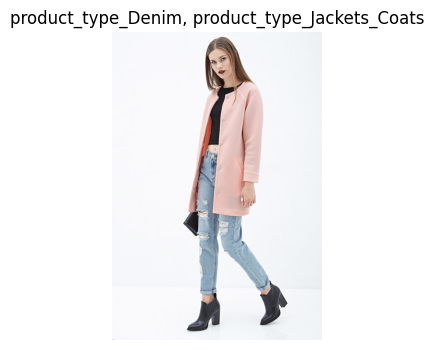

In [32]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(4,4))
plt.imshow(Image.open(img_path))
plt.axis("off")
plt.title(", ".join(pred_product_labels))
plt.show()

In [33]:
model.save('<|-_-|>.h5')